**Part 2: Model Classification**

**Summary**

This notebook allows for the image curation, model optimization, and statistical benchmarking associated with radiograph classification. Each section can be mounted seperately based upon resource requirements (gpu vs cpu). The main folder used to read/write study related files is Part2. Part A refers to the classifier which uses the pretrained encoder while Part B refers to the vanilla classifier (no pretrained encoder).The classifiers did not fit well to the data, perhaps choosing an encoder with more parameters during the in-painting phase would have resulted in better performance.

Part A
1. Hyper-parameter Optimization: /content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-sweep-2023-06-14-23-58-49/
2. Testing: /content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-test-2023-06-15-02-14-56/

Part B:
1. Hyper-parameter Optimization: /content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-sweep-2023-06-15-04-33-48/
2. Testing: /content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-test-2023-06-15-07-09-25/


# Preprocessing

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.0 MB/s eta 0:00:00


In [ ]:
#imports
import pandas as pd
import os
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection

In [ ]:
#functions

#used for finding the ID
def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

#prepare the data
def prepare_data(row):
  #get the class
  class_label = int(find_between(row['Rad_Name'], 'labeled_KL', '_image'))
  #get the id
  id = int(find_between(row['Rad_Name'], '_image', '.png'))
  #return
  return class_label, id

#resampling function for medical images
def resample_image_standardize(itk_image, out_size = (64, 64)):
  #get the original spacing
  original_spacing = itk_image.GetSpacing()
  #get the size
  original_size = itk_image.GetSize()
  #get the new spacing
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1])
                 ]
  #resampling
  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #label
  resample.SetInterpolator(sitk.sitkBSpline)
  #return
  return resample.Execute(itk_image)

#seperate into independent folds
def get_folds(df, n_splits, stratify = 'Class_Label'):
  #the splitter
  skf = sklearn.model_selection.StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
  #set the target
  target = df.loc[:, stratify].astype('category')
  #init
  df_ls = []
  #iterate
  for i, (_, fold_index) in enumerate(skf.split(df, target)):
    #set
    df_fold = df.loc[fold_index,:]
    #insert
    df_fold['Fold'] = i + 1
    #append
    df_ls.append(df_fold)
  #return
  return pd.concat(df_ls).reset_index(drop = True)

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#prepare the model input data
def prepare_inputs(row, save_path, save_folder, norm):
  #read the image data
  image = sitk.ReadImage(row['Rad'])
  #normalize
  image = minmax(image)
  #return
  return save_image(save_path, save_folder, row['Rad_Name'].replace('.png',''), image)

#minmax
def minmax(image):
  arr = sitk.GetArrayFromImage(image).astype('float32')
  arr = (arr - arr.min())/(arr.max() - arr.min())
  new_image = sitk.GetImageFromArray(arr)
  new_image.CopyInformation(image)
  return new_image

#get the normalization filter
def norm_filter(norm_type = 'minmax'):
  #minmax
  if norm_type == 'minmax':
    norm = sitk.IntensityWindowingImageFilter()
    norm.SetOutputMaximum(1)
    norm.SetOutputMinimum(0)
  #z-norm
  if norm_type == 'z':
    norm = sitk.NormalizeImageFilter()
  #return
  return norm

#obtain train test split
def dataset(df, folds, test_split):
  #split
  df_train, df_test = sklearn.model_selection.train_test_split(df, test_size = test_split,
                                                               random_state = 42, shuffle = True,
                                                               stratify = df['Class_Label'])
  #get folds for train set
  df_train = get_folds(df_train.reset_index(drop = True), folds)
  #label the test set
  df_test['Fold'] = 'Test'
  #concat
  return pd.concat([df_train, df_test]).reset_index(drop = True)

#get data
def get_data(data_path1):
  #init
  data = []

  #iterate
  for f_class in sorted(os.listdir(data_path1)):
    for patient in sorted(os.listdir(data_path1 + f_class)):
      #append
      data.append([patient, data_path1 + f_class + '/' + patient])

  #init
  return pd.DataFrame(data, columns = ['Rad_Name', 'Rad'])

In [ ]:
#init

#read in the unlabeled data
data_path1 = '/content/gdrive/MyDrive/DL_Assignment/Labeled/'
#specify the number of folds
folds = 4
#test split
test_split = 0.3
#preprocessing save locations
save_folder = 'Norm-Rad'
save_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/'

In [ ]:
%%time
#main

#read in the unlabeled data
df = get_data(data_path1)
#prepare the data
df['Class_Label'], df['ID'] = zip(*df.apply(prepare_data, axis = 1))
#specify the stratified fold splits
df = dataset(df, folds, test_split)
#print
print(df.groupby(['Fold'])['Class_Label'].value_counts())
#get norm
norm = norm_filter('minmax')
#prepare the model inputs
df[save_folder] = df.apply(prepare_inputs, axis = 1, args = (save_path, save_folder, norm))
#save the df
df.to_pickle(save_path + save_folder + '/' + 'df_inputs.pkl')

Fold  Class_Label
1     0              163
      2              108
      1               75
      3               53
      4               13
2     0              163
      2              108
      1               75
      3               53
      4               13
3     0              163
      2              107
      1               75
      3               54
      4               12
4     0              163
      2              107
      1               75
      3               54
      4               12
Test  0              280
      2              185
      1              128
      3               92
      4               21
Name: Class_Label, dtype: int64
CPU times: user 40.1 s, sys: 6.14 s, total: 46.2 s
Wall time: 6min 28s


**Introduction**
1. The filepaths to the labeled radiographs was established.
2. The dataset was stratified via class label into training set and testing sets.
3. The training set consisted of 4 independent folds, the counts are listed in the script.
4. Each 2D radiograph was min-max normalized (values fit between 0-1) and saved to serve as a model input.

**Justification**

1. Storing information on each patient-specific file in a tabular format is essential for organizing complex deep learning experiments.
2. Row-wise represents each patient and column-wise describes the patient's file.
3. A sufficient amount of testing data was taken (30% of the overall set) to determine performance for out-of-sample results. 30% was selected to ensure sufficient variety within the minority class.

**Conclusion**

1. The data has been stored in a machine-learning ready format.
2. While there are 4 independent folds in the training set, only 1 fold will be used for validation while the remaining 3 folds will be used for training (for brevity).

# Part A: Classifier with Pretrained Encoder

## Training

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00


In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, col_label, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.col_label = col_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #read label
      label = row[self.col_label]

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        if random.random() > 0.5:
          #rotate
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))

      #return x, y_true
      return image, label

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_paint_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_paint_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_paint_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )

    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)

  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#get sampler
def get_sampler(df, model_config):
  labels_unique, counts = np.unique(df[model_config['col_label']], return_counts = True)
  class_weights = [sum(counts) / c for c in counts]
  example_weights = [class_weights[e] for e in df[model_config['col_label']]]
  sampler = torch.utils.data.WeightedRandomSampler(example_weights, len(df))
  return sampler

#balanced weights dataset
def bal_weight_data(model_config, df):
  y = df[model_config['col_label']].to_numpy().astype(np.int8)
  class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
  #class_weights = torch.tensor(class_weights, dtype = torch.float)
  return class_weights

#inverse weights dataset
def inv_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  weights_for_samples = 1.0 / np.power(class_counts, model_config['loss']['power']) #0.5 ISNS or 1 INS
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#effective weights dataset
def eff_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  effective_num = 1.0 - np.power(model_config['loss']['beta'], class_counts)
  weights_for_samples = (1.0 - model_config['loss']['beta']) / effective_num
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#custom class
class CustomLoss(torch.nn.Module):
  #init
  def __init__(self, gamma = None, power = None, beta = None, description = None, device = None):
    #super
    super(CustomLoss, self).__init__()
    self.gamma = gamma
    self.power = power
    self.beta = beta
    self.description = description
    self.device = device

  #count
  def class_counting(self, arr, classes = [0, 1, 2, 3, 4]):
    #int
    count = torch.zeros(len(classes), dtype = int)
    #iterate
    for idx, c in enumerate(classes):
      #index
      count[idx] = len(arr[arr == c])
    #return
    return count

  #inverse weights batch
  def inv_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    weights_for_samples = 1.0 / torch.pow(class_counts, self.power) #0.5 ISNS or 1 INS
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #effective weights batch
  def eff_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    effective_num = 1.0 - torch.pow(self.beta, class_counts)
    weights_for_samples = (1.0 - self.beta) / effective_num
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #focal loss
  def focal_loss(self, y_pred, y_true, weight = None):
    ce_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight, reduction = "none")
    p_t = torch.exp(-ce_loss)
    loss = (1 - p_t)**self.gamma * ce_loss
    return loss.mean()

  #forward
  def forward(self, y_pred, y_true):
    #inv
    if 'inv' in self.description:
      weights = self.inv_weight_batch(y_true).to(self.device)
    #eff
    if 'eff' in self.description:
      weights = self.eff_weight_batch(y_true).to(self.device)
    #crossentropy
    if 'ce' in self.description:
      loss = torch.nn.functional.cross_entropy(y_pred, y_true, weights, reduction = "mean")
    #focal
    if 'focal' in self.description:
      loss = self.focal_loss(y_pred, y_true, weights)
    #weights
    weights = None
    if self.device == 'cuda':
      torch.cuda.empty_cache()
    #return
    return loss

#get the loss fn
def get_loss(model_config, df = None, device = None):
  #regular crossentropy dataset
  if model_config['loss']['description'] == 'ce':
    criterion = torch.nn.CrossEntropyLoss()
  #balanced weighted crossentropy dataset
  if model_config['loss']['description'] == 'bal_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(bal_weight_data(model_config, df)).to(device))
  #inverse weighted crossentropy dataset
  if model_config['loss']['description'] == 'inv_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(inv_weight_data(model_config, df)).to(device))
  #effective weighted crossentropy dataset
  if model_config['loss']['description'] == 'eff_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(eff_weight_data(model_config, df)).to(device))
  #regular focal loss dataset
  if model_config['loss']['description'] == 'focal':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = None,
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #balanced weighted focal dataset
  if model_config['loss']['description'] == 'bal_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(bal_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal dataset
  if model_config['loss']['description'] == 'inv_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(inv_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #effective weighted focal dataset
  if model_config['loss']['description'] == 'eff_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(eff_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal batch
  if model_config['loss']['description'] == 'inv_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], power = model_config['loss']['power'],
                           description = model_config['loss']['description'], device = device)
  #inverse weighted crossentropy batch
  if model_config['loss']['description'] == 'inv_ce_batch':
    criterion = CustomLoss(power = model_config['loss']['power'], description = model_config['loss']['description'], device = device)
  #effective weighted focal batch
  if model_config['loss']['description'] == 'eff_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], beta = model_config['loss']['beta'],
                           description = model_config['loss']['description'], device = device)
  #effective weighted crossentropy batch
  if model_config['loss']['description'] == 'eff_ce_batch':
    criterion = CustomLoss(beta = model_config['loss']['beta'], description = model_config['loss']['description'], device = device)
  #return
  return criterion

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x, y_true, y_pred, loss = (None, None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-classifier-kl-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[(~df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]
    #val data (in valkfolds)
    df_val = df[(df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]
    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'VAL'
    #test
    df_test = df[df['Fold'] == 'Test']
    df_test['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val, df_test])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')


    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], col_label = model_config['col_label'],
                                    aug = model_config['aug'])
    #if train sampler
    if model_config['sampler']:
      train_sampler = get_sampler(df_train, model_config)
    else:
      train_sampler = None
    #train loader
    train_loader = DataLoader(dset_train, sampler = train_sampler, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], col_label = model_config['col_label'],
                                  aug = False)
    #if val sampler
    if model_config['sampler']:
      val_sampler = get_sampler(df_val, model_config)
    else:
      val_sampler = None
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, df_train, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x, y_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        y_pred = model(x.to(device))
        #determine loss (should already be averaged)
        loss = criterion(y_pred, y_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x, y_true, y_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x, y_true) in enumerate(val_loader):
          #predict
          y_pred = model(x.to(device))
          #determine loss
          loss = criterion(y_pred, y_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x, y_true, y_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x, y_true, y_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which classifies the radiographs with the help of a pretrained encoder'},
        #project in wandb
        'project':{'value': 'OSAIL Part 2A'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'col_label': {'value': 'Class_Label'},
        'device': {'value': device},
        'val_kfolds': {'values': [[4]]}, #kfolds for validation // can specify more than one fold in a validation set
        #model architecture (must be consistent if comparing naive to pretrained encoder)
        'architecture': {'values': [
            {'description': 'smp_custom',
             'pretrained_encoder': '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-test-2023-06-12-18-18-59/2d-unet-painting-2023-06-12-18-19-01/', #path
             #not used if pretrained
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'in_channels': 1,
             #classification layers parameters
             'classes': 5,
             'pooling': 'max', #max or avg or int
             'dropout': 0}]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-5]},
        'epochs': {'values': [35]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-8]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 3,
             'threshold': 1e-2,
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
             {'description': 'eff_focal_dataset', 'gamma': 2, 'beta': 0.99},
               {'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5},
                {'description': 'eff_focal_batch', 'gamma': 2, 'beta': 0.99},
                 #{'description': 'focal', 'gamma': 2},
                  {'description': 'eff_ce_dataset', 'beta': 0.99},
                   {'description': 'inv_ce_dataset', 'power': 0.5},
                    #{'description': 'ce'}
        ]},
        #weighted random sampler
        'sampler': {'values': [False]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-3,
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


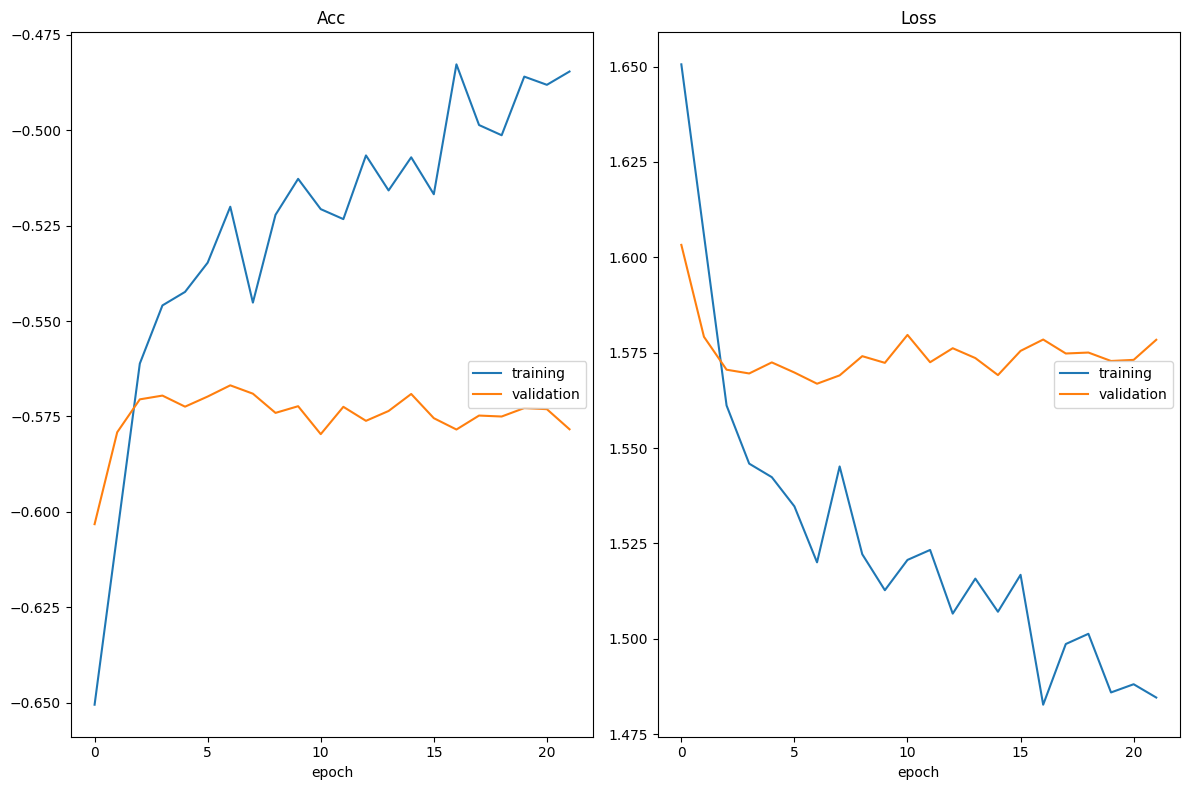

Acc
	training         	 (min:   -0.651, max:   -0.483, cur:   -0.485)
	validation       	 (min:   -0.603, max:   -0.567, cur:   -0.578)
Loss
	training         	 (min:    1.483, max:    1.651, cur:    1.485)
	validation       	 (min:    1.567, max:    1.603, cur:    1.578)
Early Stop: Exit Training


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sampler,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▅▅▆▆▆▅▆▇▆▆▇▇▇▇█▇▇███
train_loss,█▆▄▄▃▃▃▄▃▂▃▃▂▂▂▂▁▂▂▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 35min 1s, sys: 10min 11s, total: 45min 12s
Wall time: 1h 58min 34s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-classifier-sweep-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is designed to perform both k-fold cross validation and hyper-parameter optimization while communicating results to a WandB account and storing results locally.
2. The output of this code falls in the Part2/PartA/results/ folder where the sweep folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.
3. The script is the main work-horse and is responsible for reading and augmenting model inputs, collecting auxillary components (loss function, learning rate scheduler, early stopping policy, optimizer, etc), and training the deep learning model pretrained encoder + classification layer.

**Justification**

1. An attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. During preliminary studies, it was observed that the model had great difficulty fitting. As such, several different loss functions were explored for optimizing model performance.
3. Crossentropy: initial loss function used
4. Focal: loss function designed to focus on harder examples
5. Class Balanced: class specific weighting of loss functions (the minority class will have greater weights attached)

**Conclusion**

1. Hyper-parameter optimization was performed, especially across loss functions, under the belief it was the most influential parameter in developing a well-fit model.
2. It may appear that the validation set is out-performing the training set in the above plots, however, this is due to the image augmentation (the training set has harder cases).
3. Note no k-fold cross validation was performed, despite the training script being set-up to do so (for brevity).

## Inference

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )
    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)
  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image):
      #params
      self.df = df
      self.col_image = col_image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #return x
      return image

In [ ]:
#init for patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-sweep-2023-06-14-23-58-49/'
#specify the model tag
model_tag = '2d-classifier-kl'

In [ ]:
%%time

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  save_dfs = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x in enumerate(infer_loader):
    #less compute
    with torch.no_grad():
      #forward pass
      y_pred = model(x.to(device))
      #detach
      batch_prediction = y_pred.detach().cpu()
      #clear
      y_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #get the small df
    df_small = ls_df[i]
    #obtain the individual class predictions
    pred_prob = torch.softmax(batch_prediction, dim = 1)
    #obtain the class prediction by majority
    pred_class = torch.argmax(pred_prob, dim = 1)
    #class model prediction
    df_small['Class_Prediction'] = pred_class
    #individual class probabilities
    for j in range(model_config['architecture']['classes']):
      pred_tag = 'Class_' + str(j) + '_Prob'
      df_small[pred_tag] = pred_prob[:, j]
    #append
    save_dfs.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #concat
  df_pred = pd.concat(save_dfs)
  #save
  df_pred.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #print
  print('Completed: ', model_config['save_folder'])
  #clear
  model = None
  #clear
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 of 24
Finished Batch: 12 of 24
Finished Batch: 13 of 24
Finished Batch: 14 of 24
Finished Batch: 15 of 24
Finished Batch: 16 of 24
Finished Batch: 17 of 24
Finished Batch: 18 of 24
Finished Batch: 19 of 24
Finished Batch: 20 of 24
Finished Batch: 21 of 24
Finished Batch: 22 of 24
Finished Batch: 23 of 24
Finished Batch: 24 of 24
Completed:  /content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-sweep-2023-06-14-23-58-49/2d-classifier-kl-2023-06-14-23-58-50/
Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 o

**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. The df_results.pkl file will be updated with the predictions.

**Justification**

1. The script is designed to take advantage of the model's ability to batch prediction.

**Conclusion**

1. One can obtain model predictions in an organized format.

## Optimization

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#imports
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import json

In [ ]:
#functions

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get performance
def get_performance(df, model_config, encoding = ['0', '1', '2', '3', '4']):
  #iterate
  for split in set(df['Split']):
    #split data
    df_data = df[df['Split'] == split]
    #report
    config = sklearn.metrics.classification_report(df_data[model_config['col_label']].to_numpy().astype(int),
                                                   df_data['Class_Prediction'].to_numpy(), output_dict = True,
                                                   zero_division = 0)
    #save
    model_config[split + '_performance'] = config
    #plot confusion matrix
    plot_confusion_matrix(df_data[model_config['col_label']].to_numpy().astype(float), df_data['Class_Prediction'].to_numpy(),
                          split, encoding, model_config)
  #save the config
  save_params(model_config, model_config['save_folder'] + 'model_config.json')
  #return
  return model_config


#plot confusion matrix
def plot_confusion_matrix(labels, predictions, title, ticks, model_config):
    #cmap
    cm = confusion_matrix(labels, predictions)
    #sub
    ax = plt.subplot()
    sns.set(font_scale=2.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="binary", fmt="g");
    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predictions', fontdict=label_font);
    ax.set_ylabel('Class Labels', fontdict=label_font);
    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title(title, fontdict=title_font);
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust to fit
    if ticks is not None:
      ax.xaxis.set_ticklabels(ticks);
      ax.yaxis.set_ticklabels(ticks);
    #save
    plt.savefig(model_config['save_folder'] + title + '.png', bbox_inches = "tight")
    plt.close()

#analyze the performance
def analyze(model_config, tags = ['TRAIN', 'VAL', 'TEST'], encoding = ['0', '1', '2', '3', '4']):
  ls_metrics = []
  df_col = []
  #append
  ls_metrics.append(model_config['save_folder'])
  df_col.append('save_folder')
  for tag in tags:
    for class_label in (encoding +['weighted avg', 'macro avg', 'accuracy']):
      metrics = model_config[tag +'_performance'][class_label]
      #just for accuracy
      if class_label == 'accuracy':
        ls_metrics.append(metrics)
        df_col.append(tag +  ' ' + class_label)
      else:
        #all else
        for metric_type in list(metrics.keys()):
          ls_metrics.append(metrics[metric_type])
          df_col.append(tag +  ' ' + class_label + ' ' + metric_type)
  return ls_metrics, df_col

In [ ]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-sweep-2023-06-14-23-58-49/'

#specify the model tag
model_tag = '2d-classifier-kl'

#specify the most relevant columns to keep during analysis
cols = ['TRAIN weighted avg precision', 'TRAIN weighted avg recall', 'TRAIN weighted avg f1-score', 'TRAIN weighted avg support', 'TRAIN accuracy',
        'VAL weighted avg precision', 'VAL weighted avg recall', 'VAL weighted avg f1-score', 'VAL weighted avg support', 'VAL accuracy',
        'save_folder'
        ]

In [ ]:
%%time

#init
performance = []

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance
  model_config = get_performance(df, model_config)
  #analyze the performance
  model_metrics, df_cols = analyze(model_config)
  #append
  performance.append(model_metrics)
#init
df_sweep = pd.DataFrame(performance, columns = df_cols)
#sort
df_sweep = df_sweep.sort_values(by = ['VAL weighted avg f1-score', 'VAL accuracy'], ascending = False, ignore_index = True)
#save
df_sweep.to_pickle(sweep_path + 'df_opt.pkl')
#visual
display(df_sweep[cols].round(2))
#save folder
row = df_sweep.iloc[0]
#print
print(row['save_folder'])
#load
model_config = load_params(row['save_folder'] + 'model_config.json')
#print
print(model_config['loss'])
#print
#print(model_config['sampler'])

,TRAIN weighted avg precision,TRAIN weighted avg recall,TRAIN weighted avg f1-score,TRAIN weighted avg support,TRAIN accuracy,VAL weighted avg precision,VAL weighted avg recall,VAL weighted avg f1-score,VAL weighted avg support,VAL accuracy,save_folder
0,0.41,0.44,0.40,1235,0.44,0.33,0.37,0.33,411,0.37,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
1,0.40,0.41,0.34,1235,0.41,0.34,0.40,0.32,411,0.40,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
2,0.39,0.42,0.32,1235,0.42,0.31,0.40,0.30,411,0.40,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
3,0.33,0.38,0.32,1235,0.38,0.27,0.35,0.28,411,0.35,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
4,0.28,0.17,0.14,1235,0.17,0.31,0.15,0.12,411,0.15,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...


/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-sweep-2023-06-14-23-58-49/2d-classifier-kl-2023-06-15-00-27-01/
{'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5}
CPU times: user 5.65 s, sys: 1.11 s, total: 6.76 s
Wall time: 6.47 s


**Introduction**
1. By pointing to a specific sweep folder, one can determine the best performing model.
2. The df_result.pkl file is is analyzed with class specific metrics including precision, recall, f1, and accuracy and logged into the model_config.json file as well as the number of samples in each dataset.
3. These metrics are later presented in a tabular format by setting the optimization metric [VAL weighted avg f1-score, VAL accuracy].
4. In addition, confusion matrices for each dataset are created in each model  save folder.

**Justification**

1. Precision: TP / (TP + FP)
2. Recall: TP / (TP + FN)
3. F1: (2 * Precision * Recall) / (Precision + Recall)
4. Accuracy: (TP + TN) / (TP + FN + TN + FN)

**Conclusion**

1. The best performing model can be selected by viewing the performance metrics for the above table.

## Retraining

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00


In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, col_label, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.col_label = col_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #read label
      label = row[self.col_label]

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        if random.random() > 0.5:
          #rotate
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))

      #return x, y_true
      return image, label

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_paint_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_paint_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_paint_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )

    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)

  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#get sampler
def get_sampler(df, model_config):
  labels_unique, counts = np.unique(df[model_config['col_label']], return_counts = True)
  class_weights = [sum(counts) / c for c in counts]
  example_weights = [class_weights[e] for e in df[model_config['col_label']]]
  sampler = torch.utils.data.WeightedRandomSampler(example_weights, len(df))
  return sampler

#balanced weights dataset
def bal_weight_data(model_config, df):
  y = df[model_config['col_label']].to_numpy().astype(np.int8)
  class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
  class_weights = torch.tensor(class_weights, dtype = torch.float)
  return class_weights

#inverse weights dataset
def inv_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  weights_for_samples = 1.0 / np.power(class_counts, model_config['loss']['power']) #0.5 ISNS or 1 INS
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#effective weights dataset
def eff_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  effective_num = 1.0 - np.power(model_config['loss']['beta'], class_counts)
  weights_for_samples = (1.0 - model_config['loss']['beta']) / effective_num
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#custom class
class CustomLoss(torch.nn.Module):
  #init
  def __init__(self, gamma = None, power = None, beta = None, description = None, device = None):
    #super
    super(CustomLoss, self).__init__()
    self.gamma = gamma
    self.power = power
    self.beta = beta
    self.description = description
    self.device = device

  #count
  def class_counting(self, arr, classes = [0, 1, 2, 3, 4]):
    #int
    count = torch.zeros(len(classes), dtype = int)
    #iterate
    for idx, c in enumerate(classes):
      #index
      count[idx] = len(arr[arr == c])
    #return
    return count

  #inverse weights batch
  def inv_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    weights_for_samples = 1.0 / torch.pow(class_counts, self.power) #0.5 ISNS or 1 INS
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #effective weights batch
  def eff_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    effective_num = 1.0 - torch.pow(self.beta, class_counts)
    weights_for_samples = (1.0 - self.beta) / effective_num
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #focal loss
  def focal_loss(self, y_pred, y_true, weight = None):
    ce_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight, reduction = "none")
    p_t = torch.exp(-ce_loss)
    loss = (1 - p_t)**self.gamma * ce_loss
    return loss.mean()

  #forward
  def forward(self, y_pred, y_true):
    #inv
    if 'inv' in self.description:
      weights = self.inv_weight_batch(y_true).to(self.device)
    #eff
    if 'eff' in self.description:
      weights = self.eff_weight_batch(y_true).to(self.device)
    #crossentropy
    if 'ce' in self.description:
      loss = torch.nn.functional.cross_entropy(y_pred, y_true, weights, reduction = "mean")
    #focal
    if 'focal' in self.description:
      loss = self.focal_loss(y_pred, y_true, weights)
    #weights
    weights = None
    if self.device == 'cuda':
      torch.cuda.empty_cache()
    #return
    return loss

#get the loss fn
def get_loss(model_config, df = None, device = None):
  #regular crossentropy dataset
  if model_config['loss']['description'] == 'ce':
    criterion = torch.nn.CrossEntropyLoss()
  #balanced weighted crossentropy dataset
  if model_config['loss']['description'] == 'bal_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(bal_weight_data(model_config, df)).to(device))
  #inverse weighted crossentropy dataset
  if model_config['loss']['description'] == 'inv_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(inv_weight_data(model_config, df)).to(device))
  #effective weighted crossentropy dataset
  if model_config['loss']['description'] == 'eff_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(eff_weight_data(model_config, df)).to(device))
  #regular focal loss dataset
  if model_config['loss']['description'] == 'focal':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = None,
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #balanced weighted focal dataset
  if model_config['loss']['description'] == 'bal_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(bal_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal dataset
  if model_config['loss']['description'] == 'inv_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(inv_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #effective weighted focal dataset
  if model_config['loss']['description'] == 'eff_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(eff_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal batch
  if model_config['loss']['description'] == 'inv_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], power = model_config['loss']['power'],
                           description = model_config['loss']['description'], device = device)
  #inverse weighted crossentropy batch
  if model_config['loss']['description'] == 'inv_ce_batch':
    criterion = CustomLoss(power = model_config['loss']['power'], description = model_config['loss']['description'], device = device)
  #effective weighted focal batch
  if model_config['loss']['description'] == 'eff_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], beta = model_config['loss']['beta'],
                           description = model_config['loss']['description'], device = device)
  #effective weighted crossentropy batch
  if model_config['loss']['description'] == 'eff_ce_batch':
    criterion = CustomLoss(beta = model_config['loss']['beta'], description = model_config['loss']['description'], device = device)
  #return
  return criterion

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x, y_true, y_pred, loss = (None, None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-classifier-kl-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[~df['Fold'].isin(model_config['val_kfolds'])]
    #val data (in valkfolds)
    df_val = df[df['Fold'].isin(model_config['val_kfolds'])]
    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')


    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], col_label = model_config['col_label'],
                                    aug = model_config['aug'])
    #if train sampler
    if model_config['sampler']:
      train_sampler = get_sampler(df_train, model_config)
    else:
      train_sampler = None
    #train loader
    train_loader = DataLoader(dset_train, sampler = train_sampler, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], col_label = model_config['col_label'],
                                  aug = False)
    #if val sampler
    if model_config['sampler']:
      val_sampler = get_sampler(df_val, model_config)
    else:
      val_sampler = None
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, df_train, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x, y_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        y_pred = model(x.to(device))
        #determine loss (should already be averaged)
        loss = criterion(y_pred, y_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x, y_true, y_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x, y_true) in enumerate(val_loader):
          #predict
          y_pred = model(x.to(device))
          #determine loss
          loss = criterion(y_pred, y_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x, y_true, y_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x, y_true, y_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which classifies the radiographs with the help of a pretrained encoder'},
        #project in wandb
        'project':{'value': 'OSAIL Part 2A'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'col_label': {'value': 'Class_Label'},
        'device': {'value': device},
        'val_kfolds': {'values': [['Test']]}, #kfolds for validation // can specify more than one fold in a validation set
        #model architecture (must be consistent if comparing naive to pretrained encoder)
        'architecture': {'values': [
            {'description': 'smp_custom',
             'pretrained_encoder': '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-test-2023-06-12-18-18-59/2d-unet-painting-2023-06-12-18-19-01/', #path
             #not used if pretrained
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'in_channels': 1,
             #classification layers parameters
             'classes': 5,
             'pooling': 'max', #max or avg or int
             'dropout': 0}]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-5]},
        'epochs': {'values': [35]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-8]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 3,
             'threshold': 1e-2,
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
             #{'description': 'eff_focal_dataset', 'gamma': 2, 'beta': 0.99},
               {'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5},
                #{'description': 'eff_focal_batch', 'gamma': 2, 'beta': 0.99},
                 #{'description': 'focal', 'gamma': 2},
                  #{'description': 'eff_ce_dataset', 'beta': 0.99},
                   #{'description': 'inv_ce_dataset', 'power': 0.5},
                    #{'description': 'ce'}
        ]},
        #weighted random sampler
        'sampler': {'values': [False]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-3,
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


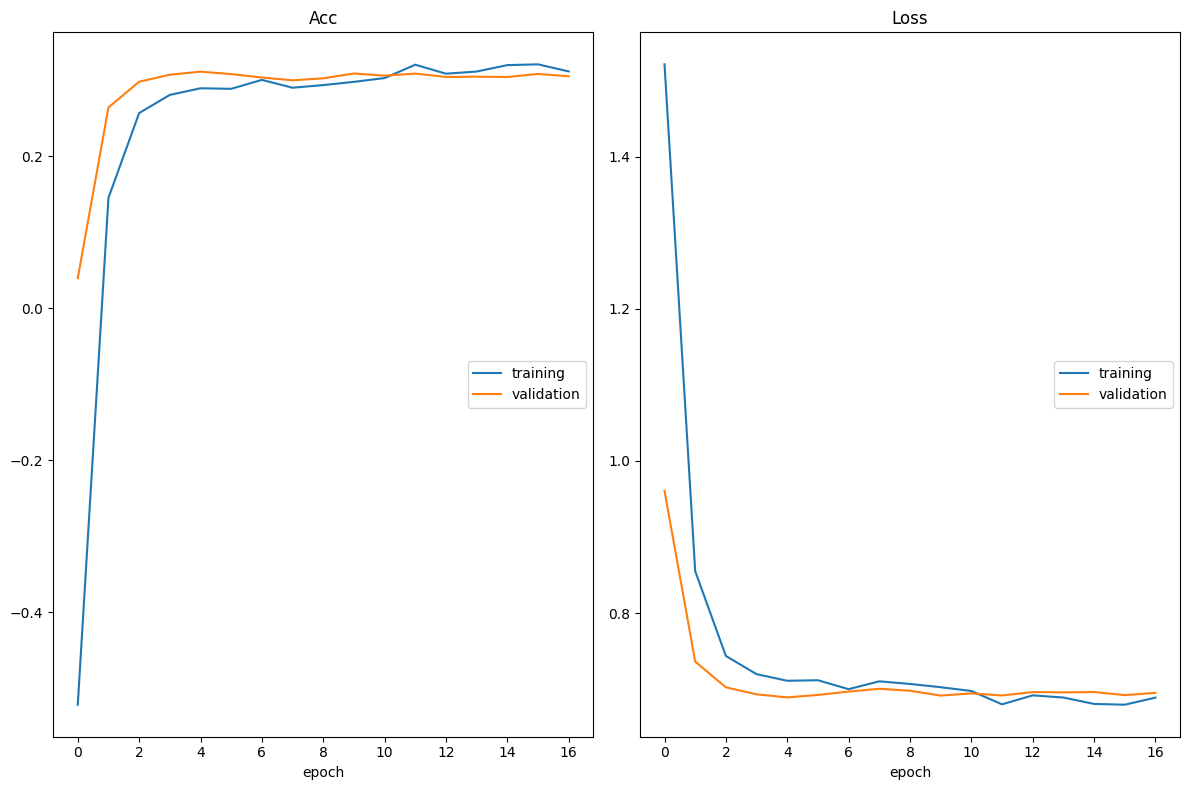

Acc
	training         	 (min:   -0.522, max:    0.321, cur:    0.311)
	validation       	 (min:    0.039, max:    0.311, cur:    0.305)
Loss
	training         	 (min:    0.679, max:    1.522, cur:    0.689)
	validation       	 (min:    0.689, max:    0.961, cur:    0.695)
Early Stop: Exit Training


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sampler,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▇▇██████████████
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 7min 35s, sys: 1min 55s, total: 9min 30s
Wall time: 31min 34s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-classifier-test-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is essentially a repeat of the previous training section, however, it treats the test set as the validation set (when plotting curves) and the model is trained on the whole dataset.
2. The output of this code falls in the Part2/PartA/results/folder where within the test folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.

**Justification**

1. The same attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. The hyper-parameters need to be updated based upon the results of the optimization exercise.
3. In retrospect, rather than training on the entire dataset, the script could also just take a pretrained model and retrain it on the missing fold to save time.

**Conclusion**

1. The best performing model as informed by the hyper-parameter optimization activity is trained on the entire training dataset.

## Testing

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )
    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)
  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image):
      #params
      self.df = df
      self.col_image = col_image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #return x
      return image

In [ ]:
#init for patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-test-2023-06-15-02-14-56/'
#specify the model tag
model_tag = '2d-classifier-kl'

In [ ]:
%%time

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  save_dfs = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x in enumerate(infer_loader):
    #less compute
    with torch.no_grad():
      #forward pass
      y_pred = model(x.to(device))
      #detach
      batch_prediction = y_pred.detach().cpu()
      #clear
      y_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #get the small df
    df_small = ls_df[i]
    #obtain the individual class predictions
    pred_prob = torch.softmax(batch_prediction, dim = 1)
    #obtain the class prediction by majority
    pred_class = torch.argmax(pred_prob, dim = 1)
    #class model prediction
    df_small['Class_Prediction'] = pred_class
    #individual class probabilities
    for j in range(model_config['architecture']['classes']):
      pred_tag = 'Class_' + str(j) + '_Prob'
      df_small[pred_tag] = pred_prob[:, j]
    #append
    save_dfs.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #concat
  df_pred = pd.concat(save_dfs)
  #save
  df_pred.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #print
  print('Completed: ', model_config['save_folder'])
  #clear
  model = None
  #clear
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 of 24
Finished Batch: 12 of 24
Finished Batch: 13 of 24
Finished Batch: 14 of 24
Finished Batch: 15 of 24
Finished Batch: 16 of 24
Finished Batch: 17 of 24
Finished Batch: 18 of 24
Finished Batch: 19 of 24
Finished Batch: 20 of 24
Finished Batch: 21 of 24
Finished Batch: 22 of 24
Finished Batch: 23 of 24
Finished Batch: 24 of 24
Completed:  /content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-test-2023-06-15-02-14-56/2d-classifier-kl-2023-06-15-02-14-57/
CPU times: user 21.6 s, sys: 6.97 s, total: 28.5 s
Wall time: 1min 16s


**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. A seperate subfolder will be created under the model-specific folder storing the model predictions and df_results.pkl will be updated with the relevant filepaths.

**Justification**

1. The script is designed to take advantage of the model's ability to batch predictions.
2. In retrospect, having the script indicate how may patients it has finished seems essential for preventing a stale environment.

**Conclusion**

1. One can obtain model predictions in an organized format.

## Evaluation

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#imports
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import json

In [ ]:
#functions

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get performance
def get_performance(df, model_config, encoding = ['0', '1', '2', '3', '4']):
  #iterate
  for split in set(df['Split']):
    #split data
    df_data = df[df['Split'] == split]
    #report
    config = sklearn.metrics.classification_report(df_data[model_config['col_label']].to_numpy().astype(int),
                                                   df_data['Class_Prediction'].to_numpy(), output_dict = True,
                                                   zero_division = 0)
    #save
    model_config[split + '_performance'] = config
    #plot confusion matrix
    plot_confusion_matrix(df_data[model_config['col_label']].to_numpy().astype(float), df_data['Class_Prediction'].to_numpy(),
                          split, encoding, model_config)
  #save the config
  save_params(model_config, model_config['save_folder'] + 'model_config.json')
  #return
  return model_config


#plot confusion matrix
def plot_confusion_matrix(labels, predictions, title, ticks, model_config):
    #cmap
    cm = confusion_matrix(labels, predictions)
    #sub
    ax = plt.subplot()
    sns.set(font_scale=2.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="binary", fmt="g");
    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predictions', fontdict=label_font);
    ax.set_ylabel('Class Labels', fontdict=label_font);
    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title(title, fontdict=title_font);
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust to fit
    if ticks is not None:
      ax.xaxis.set_ticklabels(ticks);
      ax.yaxis.set_ticklabels(ticks);
    #save
    plt.savefig(model_config['save_folder'] + title + '.png', bbox_inches = "tight")
    plt.close()

#analyze the performance
def analyze(model_config, tags = ['TRAIN', 'TEST'], encoding = ['0', '1', '2', '3', '4']):
  ls_metrics = []
  df_col = []
  #append
  ls_metrics.append(model_config['save_folder'])
  df_col.append('save_folder')
  for tag in tags:
    for class_label in (encoding +['weighted avg', 'macro avg', 'accuracy']):
      metrics = model_config[tag +'_performance'][class_label]
      #just for accuracy
      if class_label == 'accuracy':
        ls_metrics.append(metrics)
        df_col.append(tag +  ' ' + class_label)
      else:
        #all else
        for metric_type in list(metrics.keys()):
          ls_metrics.append(metrics[metric_type])
          df_col.append(tag +  ' ' + class_label + ' ' + metric_type)
  return ls_metrics, df_col

In [ ]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-test-2023-06-15-02-14-56/'
#specify the model tag
model_tag = '2d-classifier-kl'

#specify the most relevant columns to keep during analysis
cols = ['TRAIN weighted avg precision', 'TRAIN weighted avg recall', 'TRAIN weighted avg f1-score', 'TRAIN weighted avg support', 'TRAIN accuracy',
        'TEST weighted avg precision', 'TEST weighted avg recall', 'TEST weighted avg f1-score', 'TEST weighted avg support', 'TEST accuracy',
        'save_folder'
        ]

In [ ]:
%%time

#init
performance = []

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance
  model_config = get_performance(df, model_config)
  #analyze the performance
  model_metrics, df_cols = analyze(model_config)
  #append
  performance.append(model_metrics)
#init
df_sweep = pd.DataFrame(performance, columns = df_cols)
#sort
df_sweep = df_sweep.sort_values(by = ['TEST weighted avg f1-score', 'TEST accuracy'], ascending = False, ignore_index = True)
#save
df_sweep.to_pickle(sweep_path + 'df_opt.pkl')
#visual
display(df_sweep[cols].round(2))
#save folder
row = df_sweep.iloc[0]
#print
print(row['save_folder'])
#load
model_config = load_params(row['save_folder'] + 'model_config.json')
#print
print(model_config['loss'])
#print
#print(model_config['sampler'])

,TRAIN weighted avg precision,TRAIN weighted avg recall,TRAIN weighted avg f1-score,TRAIN weighted avg support,TRAIN accuracy,TEST weighted avg precision,TEST weighted avg recall,TEST weighted avg f1-score,TEST weighted avg support,TEST accuracy,save_folder
0,0.33,0.37,0.33,1646,0.37,0.32,0.35,0.32,706,0.35,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...


/content/gdrive/MyDrive/DL_Assignment/Part2/PartA/results/2d-classifier-test-2023-06-15-02-14-56/2d-classifier-kl-2023-06-15-02-14-57/
{'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5}
CPU times: user 1.39 s, sys: 53.2 ms, total: 1.44 s
Wall time: 3.57 s


**Introduction**
1. By pointing to a specific sweep folder, one can determine the best performing model.
2. The df_result.pkl file is is analyzed with class specific metrics including precision, recall, f1, and accuracy and logged into the model_config.json file as well as the number of samples in each dataset.
3. These metrics are later presented in a tabular format by setting the optimization metric [TEST weighted avg f1-score, TEST accuracy].
4. In addition, confusion matrices for each dataset are created in each model  save folder.

**Justification**

1. Precision: TP / (TP + FP)
2. Recall: TP / (TP + FN)
3. F1: (2 * Precision * Recall) / (Precision + Recall)
4. Accuracy: (TP + TN) / (TP + FN + TN + FN)

**Conclusion**

1. The best performing model can be selected by viewing the performance metrics for the above table.
2. The model's encoder might have needed more layers as it appears to be underfitting. Perhaps using the encoder from best performing vanilla (simple) classifier would be the optimal strategy.
3. Previous random weighted samplers did not improve model fitting.

# Part B: Vanilla Classifier

## Training

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00


In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, col_label, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.col_label = col_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #read label
      label = row[self.col_label]

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        if random.random() > 0.5:
          #rotate
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))

      #return x, y_true
      return image, label

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_paint_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_paint_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_paint_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )

    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)

  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#get sampler
def get_sampler(df, model_config):
  labels_unique, counts = np.unique(df[model_config['col_label']], return_counts = True)
  class_weights = [sum(counts) / c for c in counts]
  example_weights = [class_weights[e] for e in df[model_config['col_label']]]
  sampler = torch.utils.data.WeightedRandomSampler(example_weights, len(df))
  return sampler

#balanced weights dataset
def bal_weight_data(model_config, df):
  y = df[model_config['col_label']].to_numpy().astype(np.int8)
  class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
  #class_weights = torch.tensor(class_weights, dtype = torch.float)
  return class_weights

#inverse weights dataset
def inv_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  weights_for_samples = 1.0 / np.power(class_counts, model_config['loss']['power']) #0.5 ISNS or 1 INS
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#effective weights dataset
def eff_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  effective_num = 1.0 - np.power(model_config['loss']['beta'], class_counts)
  weights_for_samples = (1.0 - model_config['loss']['beta']) / effective_num
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#custom class
class CustomLoss(torch.nn.Module):
  #init
  def __init__(self, gamma = None, power = None, beta = None, description = None, device = None):
    #super
    super(CustomLoss, self).__init__()
    self.gamma = gamma
    self.power = power
    self.beta = beta
    self.description = description
    self.device = device

  #count
  def class_counting(self, arr, classes = [0, 1, 2, 3, 4]):
    #int
    count = torch.zeros(len(classes), dtype = int)
    #iterate
    for idx, c in enumerate(classes):
      #index
      count[idx] = len(arr[arr == c])
    #return
    return count

  #inverse weights batch
  def inv_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    weights_for_samples = 1.0 / torch.pow(class_counts, self.power) #0.5 ISNS or 1 INS
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #effective weights batch
  def eff_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    effective_num = 1.0 - torch.pow(self.beta, class_counts)
    weights_for_samples = (1.0 - self.beta) / effective_num
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #focal loss
  def focal_loss(self, y_pred, y_true, weight = None):
    ce_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight, reduction = "none")
    p_t = torch.exp(-ce_loss)
    loss = (1 - p_t)**self.gamma * ce_loss
    return loss.mean()

  #forward
  def forward(self, y_pred, y_true):
    #inv
    if 'inv' in self.description:
      weights = self.inv_weight_batch(y_true).to(self.device)
    #eff
    if 'eff' in self.description:
      weights = self.eff_weight_batch(y_true).to(self.device)
    #crossentropy
    if 'ce' in self.description:
      loss = torch.nn.functional.cross_entropy(y_pred, y_true, weights, reduction = "mean")
    #focal
    if 'focal' in self.description:
      loss = self.focal_loss(y_pred, y_true, weights)
    #weights
    weights = None
    if self.device == 'cuda':
      torch.cuda.empty_cache()
    #return
    return loss

#get the loss fn
def get_loss(model_config, df = None, device = None):
  #regular crossentropy dataset
  if model_config['loss']['description'] == 'ce':
    criterion = torch.nn.CrossEntropyLoss()
  #balanced weighted crossentropy dataset
  if model_config['loss']['description'] == 'bal_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(bal_weight_data(model_config, df)).to(device))
  #inverse weighted crossentropy dataset
  if model_config['loss']['description'] == 'inv_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(inv_weight_data(model_config, df)).to(device))
  #effective weighted crossentropy dataset
  if model_config['loss']['description'] == 'eff_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(eff_weight_data(model_config, df)).to(device))
  #regular focal loss dataset
  if model_config['loss']['description'] == 'focal':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = None,
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #balanced weighted focal dataset
  if model_config['loss']['description'] == 'bal_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(bal_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal dataset
  if model_config['loss']['description'] == 'inv_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(inv_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #effective weighted focal dataset
  if model_config['loss']['description'] == 'eff_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(eff_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal batch
  if model_config['loss']['description'] == 'inv_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], power = model_config['loss']['power'],
                           description = model_config['loss']['description'], device = device)
  #inverse weighted crossentropy batch
  if model_config['loss']['description'] == 'inv_ce_batch':
    criterion = CustomLoss(power = model_config['loss']['power'], description = model_config['loss']['description'], device = device)
  #effective weighted focal batch
  if model_config['loss']['description'] == 'eff_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], beta = model_config['loss']['beta'],
                           description = model_config['loss']['description'], device = device)
  #effective weighted crossentropy batch
  if model_config['loss']['description'] == 'eff_ce_batch':
    criterion = CustomLoss(beta = model_config['loss']['beta'], description = model_config['loss']['description'], device = device)
  #return
  return criterion

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x, y_true, y_pred, loss = (None, None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-classifier-kl-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[(~df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]
    #val data (in valkfolds)
    df_val = df[(df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]
    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'VAL'
    #test
    df_test = df[df['Fold'] == 'Test']
    df_test['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val, df_test])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')


    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], col_label = model_config['col_label'],
                                    aug = model_config['aug'])
    #if train sampler
    if model_config['sampler']:
      train_sampler = get_sampler(df_train, model_config)
    else:
      train_sampler = None
    #train loader
    train_loader = DataLoader(dset_train, sampler = train_sampler, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], col_label = model_config['col_label'],
                                  aug = False)
    #if val sampler
    if model_config['sampler']:
      val_sampler = get_sampler(df_val, model_config)
    else:
      val_sampler = None
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, df_train, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x, y_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        y_pred = model(x.to(device))
        #determine loss (should already be averaged)
        loss = criterion(y_pred, y_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x, y_true, y_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x, y_true) in enumerate(val_loader):
          #predict
          y_pred = model(x.to(device))
          #determine loss
          loss = criterion(y_pred, y_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x, y_true, y_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x, y_true, y_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which classifies the radiographs via a vanilla encoder'},
        #project in wandb
        'project':{'value': 'OSAIL Part 2B'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'col_label': {'value': 'Class_Label'},
        'device': {'value': device},
        'val_kfolds': {'values': [[4]]}, #kfolds for validation // can specify more than one fold in a validation set
        #model architecture (must be consistent if comparing naive to pretrained encoder)
        'architecture': {'values': [
            {'description': 'smp_custom',
             'pretrained_encoder': None, #path
             #not used if pretrained
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'in_channels': 1,
             #classification layers parameters
             'classes': 5,
             'pooling': 'max', #max or avg or int
             'dropout': 0}]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-5]},
        'epochs': {'values': [35]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-8]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 3,
             'threshold': 1e-2,
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
             {'description': 'eff_focal_dataset', 'gamma': 2, 'beta': 0.99},
               {'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5},
                {'description': 'eff_focal_batch', 'gamma': 2, 'beta': 0.99},
                 #{'description': 'focal', 'gamma': 2},
                  {'description': 'eff_ce_dataset', 'beta': 0.99},
                   {'description': 'inv_ce_dataset', 'power': 0.5},
                    #{'description': 'ce'}
        ]},
        #weighted random sampler
        'sampler': {'values': [False]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-3,
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


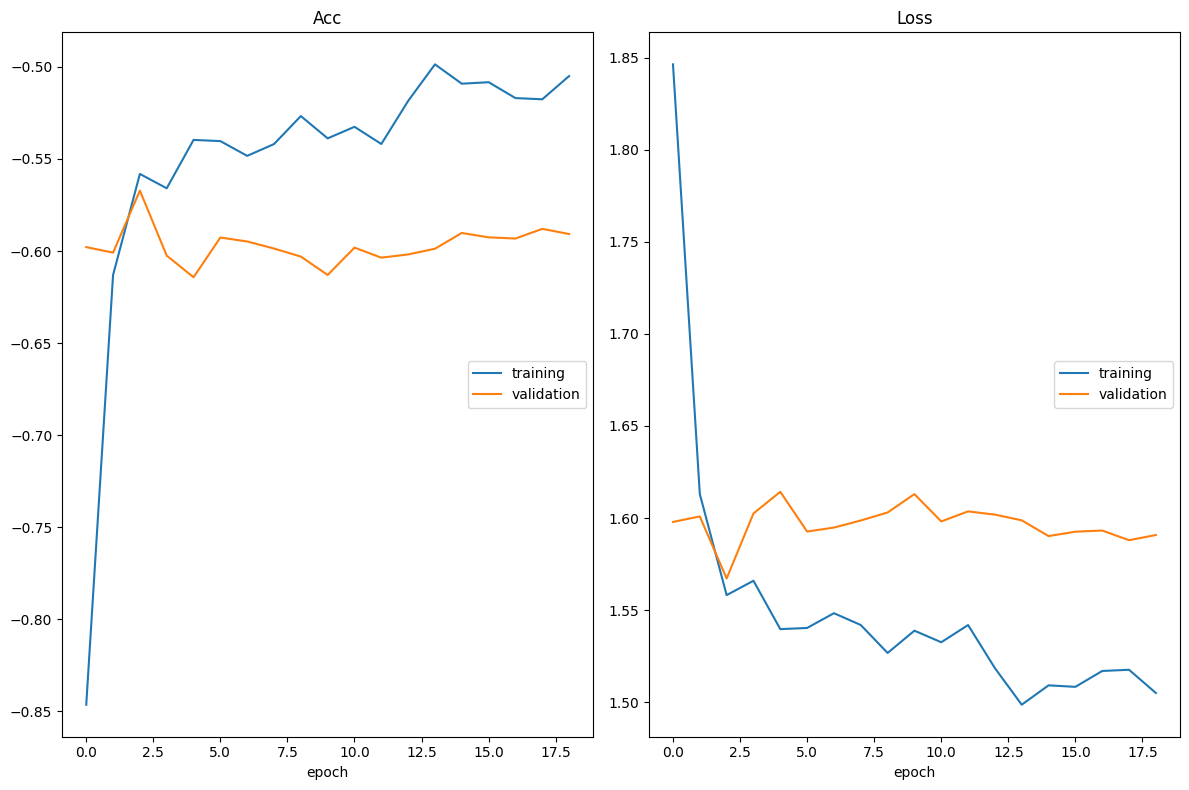

Acc
	training         	 (min:   -0.846, max:   -0.499, cur:   -0.505)
	validation       	 (min:   -0.614, max:   -0.567, cur:   -0.591)
Loss
	training         	 (min:    1.499, max:    1.846, cur:    1.505)
	validation       	 (min:    1.567, max:    1.614, cur:    1.591)
Early Stop: Exit Training


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sampler,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 39min 59s, sys: 11min 39s, total: 51min 38s
Wall time: 2h 19min 9s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-classifier-sweep-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is designed to perform both k-fold cross validation and hyper-parameter optimization while communicating results to a WandB account and storing results locally.
2. The output of this code falls in the Part2/PartB/results/ folder where the sweep folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.
3. The script is the main work-horse and is responsible for reading and augmenting model inputs, collecting auxillary components (loss function, learning rate scheduler, early stopping policy, optimizer, etc), and training the deep learning model vanilla encoder + classification layer.

**Justification**

1. An attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. During preliminary studies, it was observed that the model had great difficulty fitting. As such, several different loss functions were explored for optimizing model performance.
3. Crossentropy: initial loss function used
4. Focal: loss function designed to focus on harder examples
5. Class Balanced: class specific weighting of loss functions (the minority class will have greater weights attached)

**Conclusion**

1. Hyper-parameter optimization was performed, especially across loss functions, under the belief it was the most influential parameter in developing a well-fit model.
2. It may appear that the validation set is out-performing the training set in the above plots, however, this is due to the image augmentation (the training set has harder cases).
3. Note no k-fold cross validation was performed, despite the training script being set-up to do so (for brevity).

## Inference

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )
    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)
  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image):
      #params
      self.df = df
      self.col_image = col_image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #return x
      return image

In [ ]:
#init for patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-sweep-2023-06-15-04-33-48/'
#specify the model tag
model_tag = '2d-classifier-kl'

In [ ]:
%%time

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  save_dfs = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x in enumerate(infer_loader):
    #less compute
    with torch.no_grad():
      #forward pass
      y_pred = model(x.to(device))
      #detach
      batch_prediction = y_pred.detach().cpu()
      #clear
      y_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #get the small df
    df_small = ls_df[i]
    #obtain the individual class predictions
    pred_prob = torch.softmax(batch_prediction, dim = 1)
    #obtain the class prediction by majority
    pred_class = torch.argmax(pred_prob, dim = 1)
    #class model prediction
    df_small['Class_Prediction'] = pred_class
    #individual class probabilities
    for j in range(model_config['architecture']['classes']):
      pred_tag = 'Class_' + str(j) + '_Prob'
      df_small[pred_tag] = pred_prob[:, j]
    #append
    save_dfs.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #concat
  df_pred = pd.concat(save_dfs)
  #save
  df_pred.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #print
  print('Completed: ', model_config['save_folder'])
  #clear
  model = None
  #clear
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 of 24
Finished Batch: 12 of 24
Finished Batch: 13 of 24
Finished Batch: 14 of 24
Finished Batch: 15 of 24
Finished Batch: 16 of 24
Finished Batch: 17 of 24
Finished Batch: 18 of 24
Finished Batch: 19 of 24
Finished Batch: 20 of 24
Finished Batch: 21 of 24
Finished Batch: 22 of 24
Finished Batch: 23 of 24
Finished Batch: 24 of 24
Completed:  /content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-sweep-2023-06-15-04-33-48/2d-classifier-kl-2023-06-15-04-33-50/
Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 o

**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. The df_results.pkl file will be updated with the predictions.

**Justification**

1. The script is designed to take advantage of the model's ability to batch prediction.

**Conclusion**

1. One can obtain model predictions in an organized format.

## Optimization

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#imports
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import json

In [ ]:
#functions

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get performance
def get_performance(df, model_config, encoding = ['0', '1', '2', '3', '4']):
  #iterate
  for split in set(df['Split']):
    #split data
    df_data = df[df['Split'] == split]
    #report
    config = sklearn.metrics.classification_report(df_data[model_config['col_label']].to_numpy().astype(int),
                                                   df_data['Class_Prediction'].to_numpy(), output_dict = True,
                                                   zero_division = 0)
    #save
    model_config[split + '_performance'] = config
    #plot confusion matrix
    plot_confusion_matrix(df_data[model_config['col_label']].to_numpy().astype(float), df_data['Class_Prediction'].to_numpy(),
                          split, encoding, model_config)
  #save the config
  save_params(model_config, model_config['save_folder'] + 'model_config.json')
  #return
  return model_config


#plot confusion matrix
def plot_confusion_matrix(labels, predictions, title, ticks, model_config):
    #cmap
    cm = confusion_matrix(labels, predictions)
    #sub
    ax = plt.subplot()
    sns.set(font_scale=2.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="binary", fmt="g");
    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predictions', fontdict=label_font);
    ax.set_ylabel('Class Labels', fontdict=label_font);
    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title(title, fontdict=title_font);
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust to fit
    if ticks is not None:
      ax.xaxis.set_ticklabels(ticks);
      ax.yaxis.set_ticklabels(ticks);
    #save
    plt.savefig(model_config['save_folder'] + title + '.png', bbox_inches = "tight")
    plt.close()

#analyze the performance
def analyze(model_config, tags = ['TRAIN', 'VAL', 'TEST'], encoding = ['0', '1', '2', '3', '4']):
  ls_metrics = []
  df_col = []
  #append
  ls_metrics.append(model_config['save_folder'])
  df_col.append('save_folder')
  for tag in tags:
    for class_label in (encoding +['weighted avg', 'macro avg', 'accuracy']):
      metrics = model_config[tag +'_performance'][class_label]
      #just for accuracy
      if class_label == 'accuracy':
        ls_metrics.append(metrics)
        df_col.append(tag +  ' ' + class_label)
      else:
        #all else
        for metric_type in list(metrics.keys()):
          ls_metrics.append(metrics[metric_type])
          df_col.append(tag +  ' ' + class_label + ' ' + metric_type)
  return ls_metrics, df_col

In [ ]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-sweep-2023-06-15-04-33-48/'

#specify the model tag
model_tag = '2d-classifier-kl'

#specify the most relevant columns to keep during analysis
cols = ['TRAIN weighted avg precision', 'TRAIN weighted avg recall', 'TRAIN weighted avg f1-score', 'TRAIN weighted avg support', 'TRAIN accuracy',
        'VAL weighted avg precision', 'VAL weighted avg recall', 'VAL weighted avg f1-score', 'VAL weighted avg support', 'VAL accuracy',
        'save_folder'
        ]

In [ ]:
%%time

#init
performance = []

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance
  model_config = get_performance(df, model_config)
  #analyze the performance
  model_metrics, df_cols = analyze(model_config)
  #append
  performance.append(model_metrics)
#init
df_sweep = pd.DataFrame(performance, columns = df_cols)
#sort
df_sweep = df_sweep.sort_values(by = ['VAL weighted avg f1-score', 'VAL accuracy'], ascending = False, ignore_index = True)
#save
df_sweep.to_pickle(sweep_path + 'df_opt.pkl')
#visual
display(df_sweep[cols].round(2))
#save folder
row = df_sweep.iloc[0]
#print
print(row['save_folder'])
#load
model_config = load_params(row['save_folder'] + 'model_config.json')
#print
print(model_config['loss'])
#print
#print(model_config['sampler'])

,TRAIN weighted avg precision,TRAIN weighted avg recall,TRAIN weighted avg f1-score,TRAIN weighted avg support,TRAIN accuracy,VAL weighted avg precision,VAL weighted avg recall,VAL weighted avg f1-score,VAL weighted avg support,VAL accuracy,save_folder
0,0.43,0.44,0.37,1235,0.44,0.31,0.37,0.30,411,0.37,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
1,0.34,0.39,0.32,1235,0.39,0.29,0.36,0.28,411,0.36,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
2,0.40,0.45,0.34,1235,0.45,0.25,0.37,0.27,411,0.37,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
3,0.43,0.46,0.43,1235,0.46,0.23,0.27,0.25,411,0.27,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...
4,0.27,0.18,0.14,1235,0.18,0.34,0.15,0.13,411,0.15,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...


/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-sweep-2023-06-15-04-33-48/2d-classifier-kl-2023-06-15-04-33-50/
{'beta': 0.99, 'description': 'eff_focal_dataset', 'gamma': 2}
CPU times: user 8.11 s, sys: 1.21 s, total: 9.32 s
Wall time: 8.7 s


**Introduction**
1. By pointing to a specific sweep folder, one can determine the best performing model.
2. The df_result.pkl file is is analyzed with class specific metrics including precision, recall, f1, and accuracy and logged into the model_config.json file as well as the number of samples in each dataset.
3. These metrics are later presented in a tabular format by setting the optimization metric [VAL weighted avg f1-score, VAL accuracy].
4. In addition, confusion matrices for each dataset are created in each model  save folder.

**Justification**

1. Precision: TP / (TP + FP)
2. Recall: TP / (TP + FN)
3. F1: (2 * Precision * Recall) / (Precision + Recall)
4. Accuracy: (TP + TN) / (TP + FN + TN + FN)

**Conclusion**

1. The best performing model can be selected by viewing the performance metrics for the above table.

## Retraining

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00


In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, col_label, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.col_label = col_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #read label
      label = row[self.col_label]

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        if random.random() > 0.5:
          #rotate
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))

      #return x, y_true
      return image, label

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_paint_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_paint_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_paint_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )

    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)

  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#get sampler
def get_sampler(df, model_config):
  labels_unique, counts = np.unique(df[model_config['col_label']], return_counts = True)
  class_weights = [sum(counts) / c for c in counts]
  example_weights = [class_weights[e] for e in df[model_config['col_label']]]
  sampler = torch.utils.data.WeightedRandomSampler(example_weights, len(df))
  return sampler

#balanced weights dataset
def bal_weight_data(model_config, df):
  y = df[model_config['col_label']].to_numpy().astype(np.int8)
  class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
  #class_weights = torch.tensor(class_weights, dtype = torch.float)
  return class_weights

#inverse weights dataset
def inv_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  weights_for_samples = 1.0 / np.power(class_counts, model_config['loss']['power']) #0.5 ISNS or 1 INS
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#effective weights dataset
def eff_weight_data(model_config, df):
  y_true = df[model_config['col_label']].to_numpy().astype(np.int8)
  _, class_counts = np.unique(y_true, return_counts = True)
  effective_num = 1.0 - np.power(model_config['loss']['beta'], class_counts)
  weights_for_samples = (1.0 - model_config['loss']['beta']) / effective_num
  return weights_for_samples / np.sum(weights_for_samples) * len(class_counts)

#custom class
class CustomLoss(torch.nn.Module):
  #init
  def __init__(self, gamma = None, power = None, beta = None, description = None, device = None):
    #super
    super(CustomLoss, self).__init__()
    self.gamma = gamma
    self.power = power
    self.beta = beta
    self.description = description
    self.device = device

  #count
  def class_counting(self, arr, classes = [0, 1, 2, 3, 4]):
    #int
    count = torch.zeros(len(classes), dtype = int)
    #iterate
    for idx, c in enumerate(classes):
      #index
      count[idx] = len(arr[arr == c])
    #return
    return count

  #inverse weights batch
  def inv_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    weights_for_samples = 1.0 / torch.pow(class_counts, self.power) #0.5 ISNS or 1 INS
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #effective weights batch
  def eff_weight_batch(self, y_true):
    class_counts = self.class_counting(y_true)
    effective_num = 1.0 - torch.pow(self.beta, class_counts)
    weights_for_samples = (1.0 - self.beta) / effective_num
    weights_for_samples[weights_for_samples == float('inf')] = 1e-6
    return weights_for_samples / torch.sum(weights_for_samples) * len(class_counts)

  #focal loss
  def focal_loss(self, y_pred, y_true, weight = None):
    ce_loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight, reduction = "none")
    p_t = torch.exp(-ce_loss)
    loss = (1 - p_t)**self.gamma * ce_loss
    return loss.mean()

  #forward
  def forward(self, y_pred, y_true):
    #inv
    if 'inv' in self.description:
      weights = self.inv_weight_batch(y_true).to(self.device)
    #eff
    if 'eff' in self.description:
      weights = self.eff_weight_batch(y_true).to(self.device)
    #crossentropy
    if 'ce' in self.description:
      loss = torch.nn.functional.cross_entropy(y_pred, y_true, weights, reduction = "mean")
    #focal
    if 'focal' in self.description:
      loss = self.focal_loss(y_pred, y_true, weights)
    #weights
    weights = None
    if self.device == 'cuda':
      torch.cuda.empty_cache()
    #return
    return loss

#get the loss fn
def get_loss(model_config, df = None, device = None):
  #regular crossentropy dataset
  if model_config['loss']['description'] == 'ce':
    criterion = torch.nn.CrossEntropyLoss()
  #balanced weighted crossentropy dataset
  if model_config['loss']['description'] == 'bal_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(bal_weight_data(model_config, df)).to(device))
  #inverse weighted crossentropy dataset
  if model_config['loss']['description'] == 'inv_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(inv_weight_data(model_config, df)).to(device))
  #effective weighted crossentropy dataset
  if model_config['loss']['description'] == 'eff_ce_dataset':
    criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(eff_weight_data(model_config, df)).to(device))
  #regular focal loss dataset
  if model_config['loss']['description'] == 'focal':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = None,
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #balanced weighted focal dataset
  if model_config['loss']['description'] == 'bal_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(bal_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal dataset
  if model_config['loss']['description'] == 'inv_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(inv_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #effective weighted focal dataset
  if model_config['loss']['description'] == 'eff_focal_dataset':
    criterion = torch.hub.load('adeelh/pytorch-multi-class-focal-loss', model = 'FocalLoss',
                               alpha = torch.Tensor(eff_weight_data(model_config, df)).to(device),
                               gamma = model_config['loss']['gamma'], reduction = 'mean', force_reload = False)
  #inverse weighted focal batch
  if model_config['loss']['description'] == 'inv_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], power = model_config['loss']['power'],
                           description = model_config['loss']['description'], device = device)
  #inverse weighted crossentropy batch
  if model_config['loss']['description'] == 'inv_ce_batch':
    criterion = CustomLoss(power = model_config['loss']['power'], description = model_config['loss']['description'], device = device)
  #effective weighted focal batch
  if model_config['loss']['description'] == 'eff_focal_batch':
    criterion = CustomLoss(gamma = model_config['loss']['gamma'], beta = model_config['loss']['beta'],
                           description = model_config['loss']['description'], device = device)
  #effective weighted crossentropy batch
  if model_config['loss']['description'] == 'eff_ce_batch':
    criterion = CustomLoss(beta = model_config['loss']['beta'], description = model_config['loss']['description'], device = device)
  #return
  return criterion

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x, y_true, y_pred, loss = (None, None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-classifier-kl-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[~df['Fold'].isin(model_config['val_kfolds'])]
    #val data (in valkfolds)
    df_val = df[df['Fold'].isin(model_config['val_kfolds'])]
    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')


    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], col_label = model_config['col_label'],
                                    aug = model_config['aug'])
    #if train sampler
    if model_config['sampler']:
      train_sampler = get_sampler(df_train, model_config)
    else:
      train_sampler = None
    #train loader
    train_loader = DataLoader(dset_train, sampler = train_sampler, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], col_label = model_config['col_label'],
                                  aug = False)
    #if val sampler
    if model_config['sampler']:
      val_sampler = get_sampler(df_val, model_config)
    else:
      val_sampler = None
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, df_train, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x, y_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        y_pred = model(x.to(device))
        #determine loss (should already be averaged)
        loss = criterion(y_pred, y_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x, y_true, y_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x, y_true) in enumerate(val_loader):
          #predict
          y_pred = model(x.to(device))
          #determine loss
          loss = criterion(y_pred, y_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x, y_true, y_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x, y_true, y_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which classifies the radiographs via a vanilla encoder'},
        #project in wandb
        'project':{'value': 'OSAIL Part 2B'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'col_label': {'value': 'Class_Label'},
        'device': {'value': device},
        'val_kfolds': {'values': [['Test']]}, #kfolds for validation // can specify more than one fold in a validation set
        #model architecture (must be consistent if comparing naive to pretrained encoder)
        'architecture': {'values': [
            {'description': 'smp_custom',
             'pretrained_encoder': None, #path
             #not used if pretrained
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'in_channels': 1,
             #classification layers parameters
             'classes': 5,
             'pooling': 'max', #max or avg or int
             'dropout': 0}]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-5]},
        'epochs': {'values': [35]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-8]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 3,
             'threshold': 1e-2,
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
             {'description': 'eff_focal_dataset', 'gamma': 2, 'beta': 0.99},
               #{'description': 'inv_focal_dataset', 'gamma': 2, 'power': 0.5},
                #{'description': 'eff_focal_batch', 'gamma': 2, 'beta': 0.99},
                 #{'description': 'focal', 'gamma': 2},
                  #{'description': 'eff_ce_dataset', 'beta': 0.99},
                   #{'description': 'inv_ce_dataset', 'power': 0.5},
                    #{'description': 'ce'}
        ]},
        #weighted random sampler
        'sampler': {'values': [False]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-3,
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


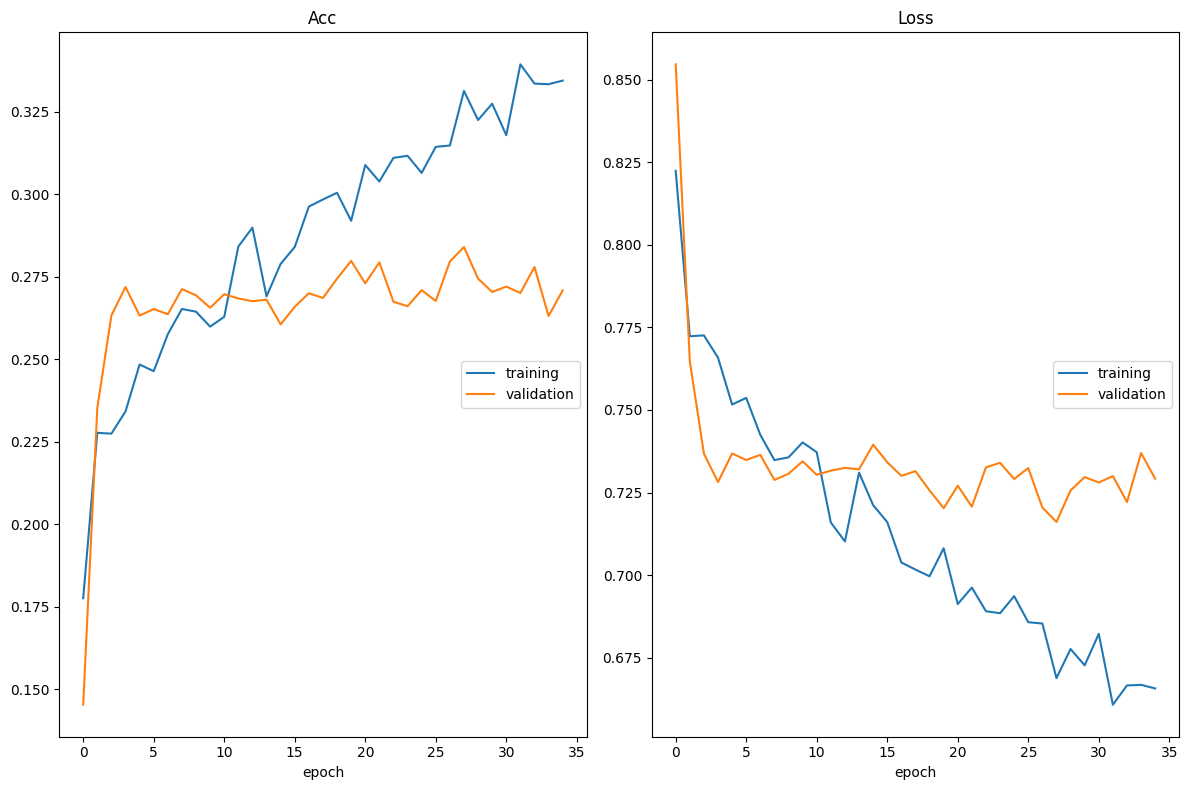

Acc
	training         	 (min:    0.178, max:    0.339, cur:    0.334)
	validation       	 (min:    0.145, max:    0.284, cur:    0.271)
Loss
	training         	 (min:    0.661, max:    0.822, cur:    0.666)
	validation       	 (min:    0.716, max:    0.855, cur:    0.729)


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sampler,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▃▃▄▄▄▅▅▅▅▆▆▅▅▆▆▆▆▆▇▆▇▇▇▇▇█▇▇▇████
train_loss,█▆▆▆▅▅▅▄▄▄▄▃▃▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 15min 50s, sys: 4min 4s, total: 19min 54s
Wall time: 1h 18min 51s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-classifier-test-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is essentially a repeat of the previous training section, however, it treats the test set as the validation set (when plotting curves) and the model is trained on the whole dataset.
2. The output of this code falls in the Part2/PartB/results/folder where within the test folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.

**Justification**

1. The same attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. The hyper-parameters need to be updated based upon the results of the optimization exercise.
3. In retrospect, rather than training on the entire dataset, the script could also just take a pretrained model and retrain it on the missing fold to save time.

**Conclusion**

1. The best performing model as informed by the hyper-parameter optimization activity is trained on the entire training dataset.

## Testing

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import ClassificationHead

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc


#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config, False)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the model
def get_model(model_config, new_model = True):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_custom':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = CustomClassifier(model_config, new_model)
  #return
  return model

#classifier
class CustomClassifier(torch.nn.Module):
  #init
  def __init__(self, model_config, new_model = True):
    #super
    super().__init__()
    #encoder
    if (model_config['architecture']['pretrained_encoder'] is not None) and new_model:
      #pretrained classifier
      base_model, _ = load_pretrained_paint_model(model_config['architecture']['pretrained_encoder'], 'cpu')
      #set
      self.encoder = base_model.encoder
      #release
      base_model = None
    else:
      #init
      self.encoder = get_encoder(name = model_config['architecture']['encoder_name'],
                                 depth = model_config['architecture']['encoder_depth'],
                                 weights = model_config['architecture']['encoder_weights'],
                                 in_channels = model_config['architecture']['in_channels'],
                                 )
    #classifier
    self.classification_head = ClassificationHead(in_channels = self.encoder.out_channels[-1],
                                                  classes = model_config['architecture']['classes'],
                                                  pooling = model_config['architecture']['pooling'],
                                                  dropout = model_config['architecture']['dropout']
                                                  )
    #classifier
    #self.classification_head = ClassificationTask(in_channels = self.encoder.out_channels[-1],
                                                  #classes = model_config['architecture']['classes'],
                                                  #pooling = 1,
                                                  #dropout = model_config['architecture']['dropout']
                                                  #)
  #forward
  def forward(self, x):
    #pass through feature maps
    features = self.encoder(x)
    #pass through classification layer (only the bottleneck layer)
    logits = self.classification_head(features[-1])
    #return
    return logits

#custom classification head
class ClassificationTask(torch.nn.Sequential):
  #init
  def __init__(self, in_channels, classes, dropout, pooling = 1):
    #super
    super().__init__()
    #specific layers
    self.pooling_layer = torch.nn.AdaptiveAvgPool2d(pooling)
    self.flatten = torch.nn.Flatten()
    self.linear1 = torch.nn.Linear(int(pooling * in_channels), int(in_channels / 2))
    self.batch_norm1 = torch.nn.BatchNorm1d(int(in_channels / 2))
    self.linear2 = torch.nn.Linear(int(in_channels / 2), int(in_channels / 4))
    self.batch_norm2 = torch.nn.BatchNorm1d(int(in_channels / 4))
    self.linear3 = torch.nn.Linear(int(in_channels / 4), int(in_channels / 8))
    #self.droput = torch.nn.Dropout(dropout)
    self.linear4 = torch.nn.Linear(int(in_channels / 8), int(in_channels / 16))
    self.linear5 = torch.nn.Linear(int(in_channels / 16), classes)
    #super
    #super().__init__(self.pooling_layer, self.flatten, self.linear1, self.batch_norm1, self.linear2,
    #               self.batch_norm2, self.linear3, self.dropout, self.linear4, self.linear5)
  #forward
  def forward(self, x):
    features = self.pooling_layer(x)
    features = self.flatten(features)
    features = self.linear1(features)
    features = self.batch_norm1(features)
    features = self.linear2(features)
    features = self.batch_norm2(features)
    features = self.linear3(features)
    #features = self.dropout(features)
    features = self.linear4(features)
    logits = self.linear5(features)
    #return
    return logits

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image):
      #params
      self.df = df
      self.col_image = col_image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      #return x
      return image

In [ ]:
#init for patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-test-2023-06-15-07-09-25/'
#specify the model tag
model_tag = '2d-classifier-kl'

In [ ]:
%%time

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  save_dfs = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x in enumerate(infer_loader):
    #less compute
    with torch.no_grad():
      #forward pass
      y_pred = model(x.to(device))
      #detach
      batch_prediction = y_pred.detach().cpu()
      #clear
      y_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #get the small df
    df_small = ls_df[i]
    #obtain the individual class predictions
    pred_prob = torch.softmax(batch_prediction, dim = 1)
    #obtain the class prediction by majority
    pred_class = torch.argmax(pred_prob, dim = 1)
    #class model prediction
    df_small['Class_Prediction'] = pred_class
    #individual class probabilities
    for j in range(model_config['architecture']['classes']):
      pred_tag = 'Class_' + str(j) + '_Prob'
      df_small[pred_tag] = pred_prob[:, j]
    #append
    save_dfs.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #concat
  df_pred = pd.concat(save_dfs)
  #save
  df_pred.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #print
  print('Completed: ', model_config['save_folder'])
  #clear
  model = None
  #clear
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 24
Finished Batch: 2 of 24
Finished Batch: 3 of 24
Finished Batch: 4 of 24
Finished Batch: 5 of 24
Finished Batch: 6 of 24
Finished Batch: 7 of 24
Finished Batch: 8 of 24
Finished Batch: 9 of 24
Finished Batch: 10 of 24
Finished Batch: 11 of 24
Finished Batch: 12 of 24
Finished Batch: 13 of 24
Finished Batch: 14 of 24
Finished Batch: 15 of 24
Finished Batch: 16 of 24
Finished Batch: 17 of 24
Finished Batch: 18 of 24
Finished Batch: 19 of 24
Finished Batch: 20 of 24
Finished Batch: 21 of 24
Finished Batch: 22 of 24
Finished Batch: 23 of 24
Finished Batch: 24 of 24
Completed:  /content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-test-2023-06-15-07-09-25/2d-classifier-kl-2023-06-15-07-09-27/
CPU times: user 23.6 s, sys: 6.79 s, total: 30.4 s
Wall time: 1min 29s


**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. A seperate subfolder will be created under the model-specific folder storing the model predictions and df_results.pkl will be updated with the relevant filepaths.

**Justification**

1. The script is designed to take advantage of the model's ability to batch predictions.
2. In retrospect, having the script indicate how may patients it has finished seems essential for preventing a stale environment.

**Conclusion**

1. One can obtain model predictions in an organized format.

## Evaluation

In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [2]:
#imports
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import json

In [3]:
#functions

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get performance
def get_performance(df, model_config, encoding = ['0', '1', '2', '3', '4']):
  #iterate
  for split in set(df['Split']):
    #split data
    df_data = df[df['Split'] == split]
    #report
    config = sklearn.metrics.classification_report(df_data[model_config['col_label']].to_numpy().astype(int),
                                                   df_data['Class_Prediction'].to_numpy(), output_dict = True,
                                                   zero_division = 0)
    #save
    model_config[split + '_performance'] = config
    #plot confusion matrix
    plot_confusion_matrix(df_data[model_config['col_label']].to_numpy().astype(float), df_data['Class_Prediction'].to_numpy(),
                          split, encoding, model_config)
  #save the config
  save_params(model_config, model_config['save_folder'] + 'model_config.json')
  #return
  return model_config


#plot confusion matrix
def plot_confusion_matrix(labels, predictions, title, ticks, model_config):
    #cmap
    cm = confusion_matrix(labels, predictions)
    #sub
    ax = plt.subplot()
    sns.set(font_scale=2.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="binary", fmt="g");
    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predictions', fontdict=label_font);
    ax.set_ylabel('Class Labels', fontdict=label_font);
    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title(title, fontdict=title_font);
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust to fit
    if ticks is not None:
      ax.xaxis.set_ticklabels(ticks);
      ax.yaxis.set_ticklabels(ticks);
    #save
    plt.savefig(model_config['save_folder'] + title + '.png', bbox_inches = "tight")
    plt.close()

#analyze the performance
def analyze(model_config, tags = ['TRAIN', 'TEST'], encoding = ['0', '1', '2', '3', '4']):
  ls_metrics = []
  df_col = []
  #append
  ls_metrics.append(model_config['save_folder'])
  df_col.append('save_folder')
  for tag in tags:
    for class_label in (encoding +['weighted avg', 'macro avg', 'accuracy']):
      metrics = model_config[tag +'_performance'][class_label]
      #just for accuracy
      if class_label == 'accuracy':
        ls_metrics.append(metrics)
        df_col.append(tag +  ' ' + class_label)
      else:
        #all else
        for metric_type in list(metrics.keys()):
          ls_metrics.append(metrics[metric_type])
          df_col.append(tag +  ' ' + class_label + ' ' + metric_type)
  return ls_metrics, df_col

In [4]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-test-2023-06-15-07-09-25/'
#specify the model tag
model_tag = '2d-classifier-kl'

#specify the most relevant columns to keep during analysis
cols = ['TRAIN weighted avg precision', 'TRAIN weighted avg recall', 'TRAIN weighted avg f1-score', 'TRAIN weighted avg support', 'TRAIN accuracy',
        'TEST weighted avg precision', 'TEST weighted avg recall', 'TEST weighted avg f1-score', 'TEST weighted avg support', 'TEST accuracy',
        'save_folder'
        ]

In [5]:
%%time

#init
performance = []

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance
  model_config = get_performance(df, model_config)
  #analyze the performance
  model_metrics, df_cols = analyze(model_config)
  #append
  performance.append(model_metrics)
#init
df_sweep = pd.DataFrame(performance, columns = df_cols)
#sort
df_sweep = df_sweep.sort_values(by = ['TEST weighted avg f1-score', 'TEST accuracy'], ascending = False, ignore_index = True)
#save
df_sweep.to_pickle(sweep_path + 'df_opt.pkl')
#visual
display(df_sweep[cols].round(2))
#save folder
row = df_sweep.iloc[0]
#print
print(row['save_folder'])
#load
model_config = load_params(row['save_folder'] + 'model_config.json')
#print
print(model_config['loss'])
#print
#print(model_config['sampler'])

,TRAIN weighted avg precision,TRAIN weighted avg recall,TRAIN weighted avg f1-score,TRAIN weighted avg support,TRAIN accuracy,TEST weighted avg precision,TEST weighted avg recall,TEST weighted avg f1-score,TEST weighted avg support,TEST accuracy,save_folder
0,0.46,0.45,0.38,1646,0.45,0.28,0.36,0.28,706,0.36,/content/gdrive/MyDrive/DL_Assignment/Part2/Pa...


/content/gdrive/MyDrive/DL_Assignment/Part2/PartB/results/2d-classifier-test-2023-06-15-07-09-25/2d-classifier-kl-2023-06-15-07-09-27/
{'beta': 0.99, 'description': 'eff_focal_dataset', 'gamma': 2}
CPU times: user 1.09 s, sys: 44.6 ms, total: 1.13 s
Wall time: 7.97 s


**Introduction**
1. By pointing to a specific sweep folder, one can determine the best performing model.
2. The df_result.pkl file is is analyzed with class specific metrics including precision, recall, f1, and accuracy and logged into the model_config.json file as well as the number of samples in each dataset.
3. These metrics are later presented in a tabular format by setting the optimization metric [TEST weighted avg f1-score, TEST accuracy].
4. In addition, confusion matrices for each dataset are created in each model  save folder.

**Justification**

1. Precision: TP / (TP + FP)
2. Recall: TP / (TP + FN)
3. F1: (2 * Precision * Recall) / (Precision + Recall)
4. Accuracy: (TP + TN) / (TP + FN + TN + FN)

**Conclusion**

1. The best performing model can be selected by viewing the performance metrics for the above table.
2. As compared to the self-supervised learning strategy with a pretrained encoder, the vanilla classifier had a much lower TEST weighted avg f1-score.